In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import zipfile


'''
Data prep and feature mapping
'''
# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# COnfirms removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"




Features with zero variance after filtering: 0


In [9]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

# Model pipeline configs
model_configs = [
    {
        'name': 'GaussianNB',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', GaussianNB())
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__var_smoothing': np.logspace(0, -9, num=100)
        }
    },
    {
        'name': 'RandomForestClassifier',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, None]
        }
    },
    {
        'name': 'SVC',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', SVC(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto']
        }
    }
]

# Perform GridSearchCV for each model configuration
for config in model_configs:
    grid_search = GridSearchCV(config['pipeline'], config['param_grid'], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test)
    
    # Calculate and print metrics for the best model of this type
    f1 = f1_score(Y_test, Y_pred, average='macro')
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"{config['name']} - Best F1 Score (Macro): {f1:.3f}, Accuracy: {accuracy:.3f}")




Fitting 5 folds for each of 800 candidates, totalling 4000 fits


KeyboardInterrupt: 

Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163', 'K13628', 'K02823', 'K07138', 'K01677',
       'K16951', 'K00940', 'K11358', 'K17828', 'K00176', 'K01679', 'K03644',
       'K09157', 'K00674', 'K07166', 'K01902', 'K03737', 'K01903', 'K07146',
       'K03635', 'K22405', 'K00177', 'K18330', 'K03575', 'K03801', 'K06980',
       'K01633', 'K00241', 'K02276', 'K00658', 'K06891', 'K00390', 'K15635',
       'K07735', 'K10563', 'K03118', 'K01698', 'K01719', 'K03660', 'K00610',
       'K00533'],
      dtype='object', name='KO')


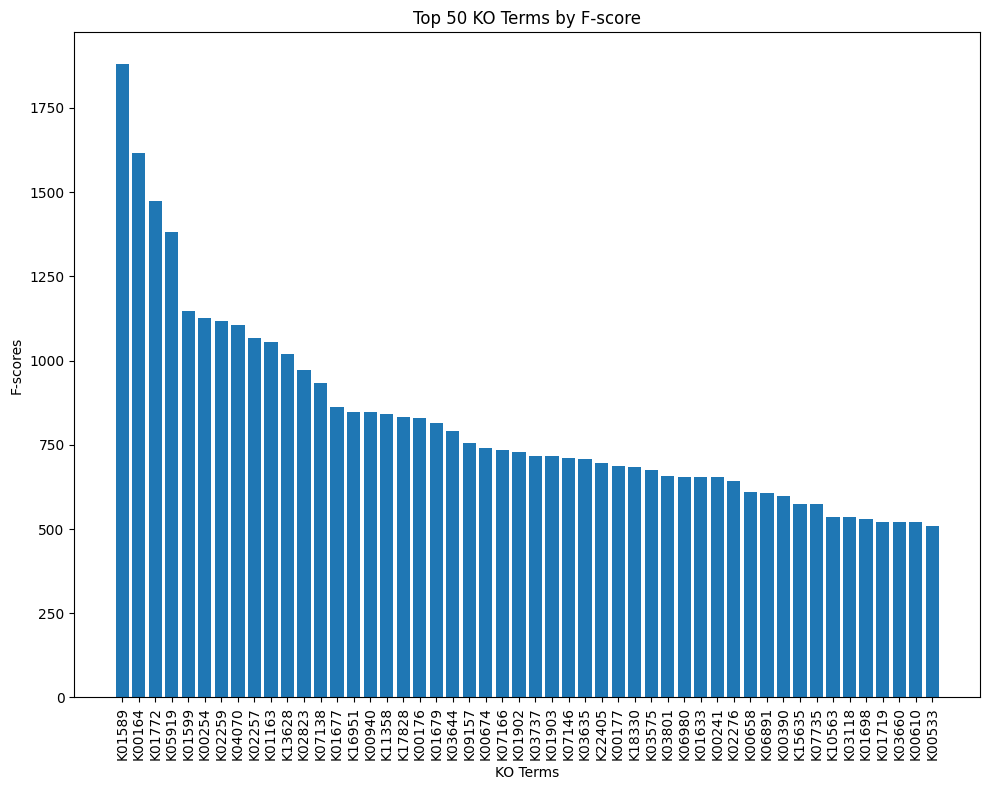

In [ ]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=50)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# bar plot shows distribution of F-scores for the selected features
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_features)), sorted_scores)
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.xlabel('KO Terms')
plt.ylabel('F-scores')
plt.title('Top 50 KO Terms by F-score')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [ ]:
''' K values versus f1 score plot'''

# MOdel configs
model_configs = [
        {
        'name': 'GaussianNB',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', GaussianNB())
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__var_smoothing': np.logspace(0, -9, num=100)
        }
    },
    {
        'name': 'RandomForestClassifier',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, None]
        }
    },
    {
        'name': 'SVC',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', SVC(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [10, 20, 30, 40, 50, 100, 200, 300],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto']
        }
    }
]

# Loop through each model configuration
for config in model_configs:
    k_values = config['param_grid']['select_k__k']  # Extract k values from the current configuration's param_grid
    f1_scores = []  # To store mean F1 scores for each k
    print(f"Processing estimator: {config}")
    
    # Perform GridSearchCV for each k value to find the best F1 score
    for k in k_values:
        print(f"Testing with k={k}")
        config['param_grid']['select_k__k'] = [k]  # Update the k value in param_grid
        grid_search = GridSearchCV(config['pipeline'], config['param_grid'], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, Y_train)
        
        # Store the best F1 score for the current k
        f1_scores.append(grid_search.best_score_)
    
    # Plot F1 scores vs. k for the current estimator
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, f1_scores, marker='o', linestyle='-', label=config['name'])
    plt.xlabel('Number of Features (k)')
    plt.ylabel('F1 Score (Macro)')
    plt.title(f'F1 Score vs. K for {config['name']}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Find and print the best overall performance for the current estimator
    max_f1_index = np.argmax(f1_scores)  # Index of the best F1 score
    best_k = k_values[max_f1_index]  # k value for the best F1 score
    print(f"{config['name']} - Best F1 Score (Macro): {f1_scores[max_f1_index]:.3f} at k={best_k}")


Processing estimator: GaussianNB
Testing with k=1
Testing with k=6
Testing with k=11
Testing with k=16
Testing with k=21
Testing with k=26
Testing with k=31
Testing with k=36
Testing with k=41
Testing with k=46
Testing with k=51
Testing with k=56
Testing with k=61
Testing with k=66
Testing with k=71
Testing with k=76
Testing with k=81
Testing with k=86
Testing with k=91
Testing with k=96
Testing with k=101
Testing with k=106
Testing with k=111
Testing with k=116
Testing with k=121
Testing with k=126
Testing with k=131
Testing with k=136
Testing with k=141
Testing with k=146
Testing with k=151
Testing with k=156
Testing with k=161
Testing with k=166
Testing with k=171
Testing with k=176
Testing with k=181
Testing with k=186
Testing with k=191
Testing with k=196
Testing with k=201
Testing with k=206
Testing with k=211
Testing with k=216
Testing with k=221
Testing with k=226
Testing with k=231
Testing with k=236
Testing with k=241
Testing with k=246
Testing with k=251
Testing with k=256
T

In [ ]:
''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")



Class distribution in Y_train:
 aerobic      1909
anaerobic     370
Name: count, dtype: int64
Unique labels in Y_train: ['aerobic' 'anaerobic']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279
